# ***Stroke Prediction: Harnessing the Power of Polars DataFrames***

**Problem Statement**

Cardiovascular diseases, including strokes, are a leading cause of morbidity and mortality worldwide. In the pursuit of advancing stroke prediction methodologies, this project aims to leverage the efficiency and speed of Polars DataFrames, avoiding the conventional use of Pandas. The objective is to develop a robust and scalable stroke prediction model that harnesses the capabilities of Polars for streamlined data processing and analysis.





In [ ]:
import polars as pl
from scipy.stats import chi2_contingency,stats
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, train_test_split,validation_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder,RobustScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [ ]:
df=pl.read_csv("/content/healthcare-dataset-stroke-data.csv", use_pyarrow=True)
df.head(10)

id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
i64,str,f64,i64,i64,str,str,str,f64,f64,str,i64
9046,"""Male""",67.0,0,1,"""Yes""","""Private""","""Urban""",228.69,36.6,"""formerly smoke…",1
51676,"""Female""",61.0,0,0,"""Yes""","""Self-employed""","""Rural""",202.21,null,"""never smoked""",1
31112,"""Male""",80.0,0,1,"""Yes""","""Private""","""Rural""",105.92,32.5,"""never smoked""",1
60182,"""Female""",49.0,0,0,"""Yes""","""Private""","""Urban""",171.23,34.4,"""smokes""",1
1665,"""Female""",79.0,1,0,"""Yes""","""Self-employed""","""Rural""",174.12,24.0,"""never smoked""",1
56669,"""Male""",81.0,0,0,"""Yes""","""Private""","""Urban""",186.21,29.0,"""formerly smoke…",1
53882,"""Male""",74.0,1,1,"""Yes""","""Private""","""Rural""",70.09,27.4,"""never smoked""",1
10434,"""Female""",69.0,0,0,"""No""","""Private""","""Urban""",94.39,22.8,"""never smoked""",1
27419,"""Female""",59.0,0,0,"""Yes""","""Private""","""Rural""",76.15,null,"""Unknown""",1


In [ ]:
# You can use lazyframe to read dataframe-This is an optimised method to read the data(displays only randomly selected rows-using fetch(no of rows you need to display)
df_lazy=pl.scan_csv("/content/healthcare-dataset-stroke-data.csv")
df_lazy.fetch(10)

id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
i64,str,i64,i64,i64,str,str,str,f64,str,str,i64
9046,"""Male""",67,0,1,"""Yes""","""Private""","""Urban""",228.69,"""36.6""","""formerly smoke…",1
51676,"""Female""",61,0,0,"""Yes""","""Self-employed""","""Rural""",202.21,"""N/A""","""never smoked""",1
31112,"""Male""",80,0,1,"""Yes""","""Private""","""Rural""",105.92,"""32.5""","""never smoked""",1
60182,"""Female""",49,0,0,"""Yes""","""Private""","""Urban""",171.23,"""34.4""","""smokes""",1
1665,"""Female""",79,1,0,"""Yes""","""Self-employed""","""Rural""",174.12,"""24""","""never smoked""",1
56669,"""Male""",81,0,0,"""Yes""","""Private""","""Urban""",186.21,"""29""","""formerly smoke…",1
53882,"""Male""",74,1,1,"""Yes""","""Private""","""Rural""",70.09,"""27.4""","""never smoked""",1
10434,"""Female""",69,0,0,"""No""","""Private""","""Urban""",94.39,"""22.8""","""never smoked""",1
27419,"""Female""",59,0,0,"""Yes""","""Private""","""Rural""",76.15,"""N/A""","""Unknown""",1


**Dataset Description: Stroke Prediction**

The dataset contains information related to stroke prediction, with each record representing an individual. Below is a description of the columns in the dataset:

1. id: Unique identifier for each individual.

2. gender: Gender of the individual (categorical: 'Male', 'Female', 'Other').

3. age: Age of the individual in years (numeric).

4. hypertension: Binary indicator for the presence of hypertension (0 for No, 1 for Yes).

5. heart_disease: Binary indicator for the presence of heart disease (0 for No, 1 for Yes).

6. ever_married: Marital status of the individual (categorical: 'Yes', 'No').

7. work_type: Type of work the individual is engaged in (categorical: 'Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked').

8. Residence_type: Type of residence of the individual (categorical: 'Urban', 'Rural').

9. avg_glucose_level: Average glucose level in the blood (numeric).

8. bmi: Body Mass Index (numeric).

9. smoking_status: Smoking status of the individual (categorical: 'smokes', 'formerly smoked', 'never smoked', 'Unknown').

10. stroke: Binary indicator for the occurrence of a stroke (0 for No, 1 for Yes). This is the target variable.

In [ ]:
print(f"The total number of rows : {df.select(pl.count()).item()}")
print(f"The total number of columns: {len(df.columns)}")

The total number of rows : 5110
The total number of columns: 12


**Expolrartry Data Analysis Using Polars**

In [ ]:
df.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [ ]:
#Statistical Summary of the dataframe
df.describe()

describe,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
str,f64,str,f64,f64,f64,str,str,str,f64,f64,str,f64
"""count""",5110.0,"""5110""",5110.0,5110.0,5110.0,"""5110""","""5110""","""5110""",5110.0,5110.0,"""5110""",5110.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,"""0""","""0""","""0""",0.0,201.0,"""0""",0.0
"""mean""",36517.829354,null,43.226614,0.097456,0.054012,null,null,null,106.147677,28.893237,null,0.048728
"""std""",21161.721625,null,22.612647,0.296607,0.226063,null,null,null,45.28356,7.854067,null,0.21532
"""min""",67.0,"""Female""",0.08,0.0,0.0,"""No""","""Govt_job""","""Rural""",55.12,10.3,"""Unknown""",0.0
"""max""",72940.0,"""Other""",82.0,1.0,1.0,"""Yes""","""children""","""Urban""",271.74,97.6,"""smokes""",1.0
"""median""",36932.0,null,45.0,0.0,0.0,null,null,null,91.885,28.1,null,0.0
"""25%""",17740.0,null,25.0,0.0,0.0,null,null,null,77.24,23.5,null,0.0
"""75%""",54695.0,null,61.0,0.0,0.0,null,null,null,114.09,33.1,null,0.0


In [ ]:
#df.glimpse() - is similar to glimpse() in R it displays the sturturce of dataframe (data types) and few rows of the dataframe (can be used instead of df.info())
df.glimpse()

Rows: 5110
Columns: 12
$ id                <i64> 9046, 51676, 31112, 60182, 1665, 56669, 53882, 10434, 27419, 60491
$ gender            <str> Male, Female, Male, Female, Female, Male, Male, Female, Female, Female
$ age               <f64> 67.0, 61.0, 80.0, 49.0, 79.0, 81.0, 74.0, 69.0, 59.0, 78.0
$ hypertension      <i64> 0, 0, 0, 0, 1, 0, 1, 0, 0, 0
$ heart_disease     <i64> 1, 0, 1, 0, 0, 0, 1, 0, 0, 0
$ ever_married      <str> Yes, Yes, Yes, Yes, Yes, Yes, Yes, No, Yes, Yes
$ work_type         <str> Private, Self-employed, Private, Private, Self-employed, Private, Private, Private, Private, Private
$ Residence_type    <str> Urban, Rural, Rural, Urban, Rural, Urban, Rural, Urban, Rural, Urban
$ avg_glucose_level <f64> 228.69, 202.21, 105.92, 171.23, 174.12, 186.21, 70.09, 94.39, 76.15, 58.57
$ bmi               <f64> 36.6, None, 32.5, 34.4, 24.0, 29.0, 27.4, 22.8, None, 24.2
$ smoking_status    <str> formerly smoked, never smoked, never smoked, smokes, never smoked, formerly smoked, 

# **Gender Analysis**

In [ ]:
df.groupby("gender").count()

gender,count
str,u32
"""Other""",1
"""Female""",2994
"""Male""",2115


There only one class: other. There is no necassity of keeping class: ***other***, I recommend to replace other with "Male" than replacing with "Female".

In [ ]:
df = df.with_columns(
    pl.when(pl.col("gender") == "Other")
    .then("Male").otherwise(pl.col("gender")) # keep original value
     .keep_name())

In [ ]:
df.groupby("gender").count()

gender,count
str,u32
"""Male""",2116
"""Female""",2994


In [ ]:
px.bar(df, x=list(df["gender"]),color="gender",width=800, height=400)

Therefore there is no association between the gender and stroke.


# **Target column (Stroke) Analysis**

In [ ]:
df.groupby("stroke").count()

stroke,count
i64,u32
0,4861
1,249


In [ ]:
fig =px.pie(df,names="stroke",color="gender",title="Stroke and No Stroke percentage", color_discrete_sequence=['#4c78a8', '#6b92bc'], hole=0.7,width=800, height=400)
fig.update_layout(plot_bgcolor='#fafafa')
fig.show()

# **Age Distribution**

In [ ]:
px.histogram(df,x="age",width=800,height=500,color="age")

* Age is not normally distributed

* people at age 72 and their count is 102 , This shows at this age people are more than compared to other.

In [ ]:
px.box(df,y="age",width=500,height=500)

Empirical cumulative distribution function plots

* Helps us to understand the distribution of a variable (age).

* It allows us to compare the age at which people will get stroke and no stroke with the help of distribution.



In [ ]:
px.ecdf(df, x='age', color='stroke', labels={'stroke': 'Stroke'},width=800, height=400)

Analysis:

*  50% of the individuals in this dataset have a stroke by the age of 71.

* 50% of the data shows that people are not getting strokes from the age of 42 to 82. i.e individuals in this age range have not experienced a stroke up to the 50th percentile.

# **Hyper-tension Analysis**

In [ ]:
df.groupby("hypertension").count()

hypertension,count
i64,u32
0,4612
1,498


In [ ]:
import pandas as pd
correlation_matrix = pd.crosstab(df['hypertension'], df['stroke'])
chi2, p, _, _ = chi2_contingency(correlation_matrix)

print(f"Chi-square test statistic: {chi2}")
print(f"P-value: {p}")


Chi-square test statistic: 81.6053682482931
P-value: 1.661621901511823e-19


The chi-square test is commonly used to assess the association between categorical variables

Therefore there is a association between the target variable and hypertension.

# **Work type Analysis**

In [ ]:
px.histogram(df, x=list(df["work_type"]),color="work_type",width=800, height=400)

# **Smoking status Analysis**

In [ ]:
df.groupby("smoking_status").count()

smoking_status,count
str,u32
"""never smoked""",1892
"""Unknown""",1544
"""smokes""",789
"""formerly smoke…",885


In [ ]:
fig =px.pie(df,names="smoking_status",color="smoking_status",title="smoking status Analysis using Piechart", color_discrete_sequence=['#4c78a8', '#6b92bc'],width=800, height=400)


# **Residence type Analysis**

In [ ]:
df.groupby("Residence_type").count()

Residence_type,count
str,u32
"""Rural""",2514
"""Urban""",2596


In [ ]:
px.histogram(df, x=list(df["Residence_type"]),color="Residence_type",width=800, height=400)

# **BMI analysis**

In [ ]:
fig=px.histogram(df,x="bmi",height=500,width=500)
fig.show()

In [ ]:
px.box(df,y="bmi",width=500,height=500)

This shows that the highest value of bmi is 97.6 which indicates obesity.Therefore there is no need for removing outliers for BMI. Hence we can scale the values.

In [ ]:
px.ecdf(df, x='bmi', color='stroke', labels={'stroke': 'Stroke'},width=800, height=400)

50% of data shows (cumulative probability) the bmi starts at 28 when the people is not affected with stroke

On the otherhand people having stroke the bmi starts at 31.
While there may be an association between higher BMI and an increased likelihood of stroke, it's crucial to recognize that correlation does not imply causation,the important thing to note that having high bmi not always implies that  a person have stroke. but this will a chance of getting stroke, because the stroke is depends on many other features.

#  Average Gluclose level Analysis

In [ ]:
fig = px.histogram(df, x="avg_glucose_level",height=500,width=500)
fig.show()

In [ ]:
px.box(df,y="avg_glucose_level",width=500,height=500)

A person can have sugar level above 260 which shows a high risk. There is no need to remove the outliers.

In [ ]:
px.ecdf(df, x='avg_glucose_level', color='stroke', labels={'stroke': 'Stroke'},width=800, height=400)

In [ ]:
#This can be used to understand the total number of unique values in all columns in the dataset.
df_nunique = df.select(pl.all().n_unique())
df_nunique

id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
5110,2,104,2,2,2,5,2,3979,419,4,2


In [ ]:
# There is also an equivalent method for returning the unique values per-group:
df_agg_nunique=df.select(df.groupby(by=["age"], maintain_order=True).n_unique())
df_agg_nunique.sort("age")
df_agg_nunique.head(5)

age,id,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
67.0,49,2,2,2,1,3,2,48,41,4,2
61.0,76,2,2,2,2,3,2,75,60,4,2
80.0,70,2,2,2,2,3,2,70,58,4,2
49.0,79,2,2,2,2,3,2,79,66,4,2
79.0,85,2,2,2,2,3,2,85,63,4,2


In [ ]:
print(df.select(pl.col("smoking_status")).n_unique())

4


In [ ]:
#To count the number of unqiue values
df_nunique=df.groupby("smoking_status").count()
df_nunique.sort("count")

smoking_status,count
str,u32
"""smokes""",789
"""formerly smoke…",885
"""Unknown""",1544
"""never smoked""",1892


In [ ]:
# estimated_size() - Return an estimation of the total (heap) allocated size of the DataFrame.
df.estimated_size()

650449

In [ ]:
# is_duplicated - Get a mask of duplicated values in the dataset

print(df.is_duplicated())

shape: (5_110,)
Series: '' [bool]
[
	false
	false
	false
	false
	false
	false
	false
	false
	false
	false
	false
	false
	…
	false
	false
	false
	false
	false
	false
	false
	false
	false
	false
	false
	false
	false
]


In [ ]:
# null_count - used to check whether the dataset contains empty (missing values)
df.null_count()

id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,201,0,0


In [ ]:
# to get an overview about the number of null values that each columns have.

print(df.select(pl.col(['smoking_status','age']).null_count()))

shape: (1, 2)
┌────────────────┬─────┐
│ smoking_status ┆ age │
│ ---            ┆ --- │
│ u32            ┆ u32 │
╞════════════════╪═════╡
│ 0              ┆ 0   │
└────────────────┴─────┘


In [ ]:
no_Stroke=df.select(pl.col("stroke").alias("absence of stroke").filter((pl.col("stroke")==0)))

In [ ]:
no_Stroke.limit(5)

absence of stroke
i64
0
0
0
0
0


In [ ]:
Stroke=df.select(pl.col("stroke").alias("Presence of Stroke").filter((pl.col("stroke")==1)))

In [ ]:
Stroke.head(5)

Presence of Stroke
i64
1
1
1
1
1


In [ ]:
print(f"The number of rows contained no stroke :{len(no_Stroke)}")
print(f"The number of rows contained stroke :{len(Stroke)}")

The number of rows contained no stroke :4861
The number of rows contained stroke :249


In [ ]:
df.head(1)

id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
i64,str,f64,i64,i64,str,str,str,f64,f64,str,i64
9046,"""Male""",67.0,0,1,"""Yes""","""Private""","""Urban""",228.69,36.6,"""formerly smoke…",1


In [ ]:
df=df.drop(["id"])

In [ ]:
df.head(4)

gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
str,f64,i64,i64,str,str,str,f64,f64,str,i64
"""Male""",67.0,0,1,"""Yes""","""Private""","""Urban""",228.69,36.6,"""formerly smoke…",1
"""Female""",61.0,0,0,"""Yes""","""Self-employed""","""Rural""",202.21,null,"""never smoked""",1
"""Male""",80.0,0,1,"""Yes""","""Private""","""Rural""",105.92,32.5,"""never smoked""",1
"""Female""",49.0,0,0,"""Yes""","""Private""","""Urban""",171.23,34.4,"""smokes""",1


Handling Missing Values

There the column Symptoms has missing values thorugh heatmap and polars dataframe we can clearly identify there are 2500 misisng values related to symptoms columns

Ways to Fill missing values through the use of polar ways to handle missing value.
Inorder to fill the missing values in the polars dataframe we can use fill_null() or fill_nan() which is smiliar to fill_na()

@ df=df.select(pl.col("Symptoms").fill_null("any value"))

@ df=df.select(pl.col("Symptoms").fill_null(strategy="forward"))

@ df=df.select(pl.col("Symptoms").fill_null(strategy="backward"))

<Axes: >

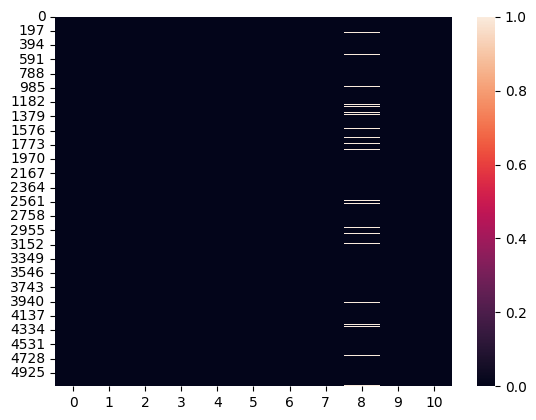

In [ ]:
# Missing values and Handling of missing values
import seaborn as sns
sns.heatmap(df.select(pl.all().is_null()))

In [ ]:
print(df.select(pl.all().is_null()).sum())

shape: (1, 11)
┌────────┬─────┬──────────────┬───────────────┬───┬────────────────┬─────┬────────────────┬────────┐
│ gender ┆ age ┆ hypertension ┆ heart_disease ┆ … ┆ avg_glucose_le ┆ bmi ┆ smoking_status ┆ stroke │
│ ---    ┆ --- ┆ ---          ┆ ---           ┆   ┆ vel            ┆ --- ┆ ---            ┆ ---    │
│ u32    ┆ u32 ┆ u32          ┆ u32           ┆   ┆ ---            ┆ u32 ┆ u32            ┆ u32    │
│        ┆     ┆              ┆               ┆   ┆ u32            ┆     ┆                ┆        │
╞════════╪═════╪══════════════╪═══════════════╪═══╪════════════════╪═════╪════════════════╪════════╡
│ 0      ┆ 0   ┆ 0            ┆ 0             ┆ … ┆ 0              ┆ 201 ┆ 0              ┆ 0      │
└────────┴─────┴──────────────┴───────────────┴───┴────────────────┴─────┴────────────────┴────────┘


In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder

def filling_missing(df):
    strategy = input("Enter the way you need to fill missing values: \n 1. Mean \n 2. Forward \n 3. Backward ")

    match strategy.lower():
        case "mean":
            df=df.fill_null(strategy="mean")
            return df
        case "forward":
            df=df.fill_null(strategy="forward")
            return df
        case "backward":
            df=df.fill_null(strategy="backward")
            return df


In [ ]:
df=filling_missing(df)

Enter the way you need to fill missing values: 
 1. Mean 
 2. Forward 
 3. Backward forward


<Axes: >

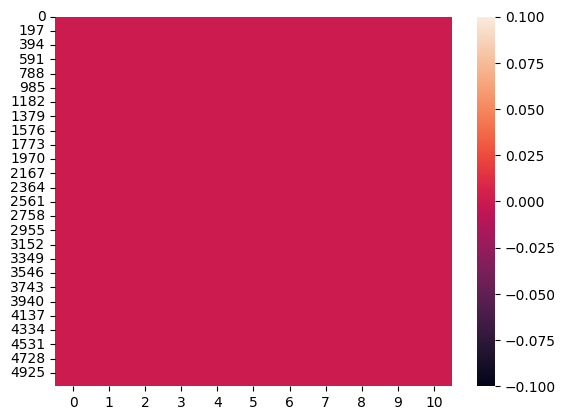

In [ ]:
# Missing values and Handling of missing values
import seaborn as sns
sns.heatmap(df.select(pl.all().is_null()))

Distribution Plot

In [ ]:
!pip install colorama

In [ ]:
import colorama
from colorama import Fore, Style
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
import numpy as np

In [ ]:
class Visualisation:

    def histogram(self, df, columns: List[str],colors) -> None:
        print(Fore.BLUE + "Histogram plot - Analysising Data Distribution")
        for col,colors in zip(columns,colors):
            plt.figure(figsize=(10,5))
            sns.histplot(data=df, x=col, kde=False,color=colors,line_kws={'color': 'b',"lw":4,'linestyle': 'dashed'},stat='density')
            plt.title(f'Histogram of {col}')
            plt.show()

    def correlation(self, df, target_column: str) -> None:
        print(Fore.RED + "Correlation Plots for numerical data")
        df1 = df.select(pl.col(pl.Int64))
        #df_transformed = df.with_columns(pl.col(target_column).map_dict({0: 0, 1: 1})).select(pl.col(target_column).alias(target_column))
        #print(df_transformed)
        #df_transformed=df.select(pl.col(target_column))
        #df_transformed=df_transformed.select(pl.col(target_column))
        #df_merged = df1.hstack(df_transformed)
        f,ax=plt.subplots(figsize=(10,5))
        corr=df1.corr()
        sns.heatmap(corr,cmap=sns.diverging_palette(220,10,as_cmap=True),vmin=-1.0,vmax=1.0,square=True,ax=ax,annot=True)
        plt.title(f'Features Correlating with {target_column}', fontsize=18, pad=16)
        plt.show()

    def scatterplot(self,df,target_column,columns):
        for col in columns:
            sns.scatterplot(data=df, x=col, y=target_column,sizes=(20, 200))
            plt.show()
    #chisquare test is a hyposthesis test used to determine association between categorical variables
    # null hypothesis : There is no relationship betwenn the variables
    # alternative hypothesis : There is a relationship betwenn the variables
    import pandas as pd
    def chisquare_test(self,df,target_column):
        df1 = df.select(pl.col(pl.Utf8))
        df= df1.hstack(df.select(pl.col(target_column)))
        for col in df.columns:
            data_crosstab = pd.crosstab(df[col],df[target_column],margins = False)
            print(data_crosstab)
            chi2, p, dof, expected = chi2_contingency(data_crosstab)
            # Interpret the results
            if p < 0.05:  # Assuming a 0.05 significance level
                print(f"There is a significant association between {col} and {target_column}.")
            else:
               print(f"There is no significant association between {col} and {target_column}.")

visualise= Visualisation()

In [ ]:
visualise.chisquare_test(df,"stroke")

col_0      0    1
row_0            
Female  2853  141
Male    2008  108
There is no significant association between gender and stroke.
col_0     0    1
row_0           
No     1728   29
Yes    3133  220
There is a significant association between ever_married and stroke.
col_0             0    1
row_0                   
Govt_job        624   33
Never_worked     22    0
Private        2776  149
Self-employed   754   65
children        685    2
There is a significant association between work_type and stroke.
col_0     0    1
row_0           
Rural  2400  114
Urban  2461  135
There is no significant association between Residence_type and stroke.
col_0               0   1
row_0                    
Unknown          1497  47
formerly smoked   815  70
never smoked     1802  90
smokes            747  42
There is a significant association between smoking_status and stroke.
col_0     0    1
row_0           
0      4861    0
1         0  249
There is a significant association between stroke and st

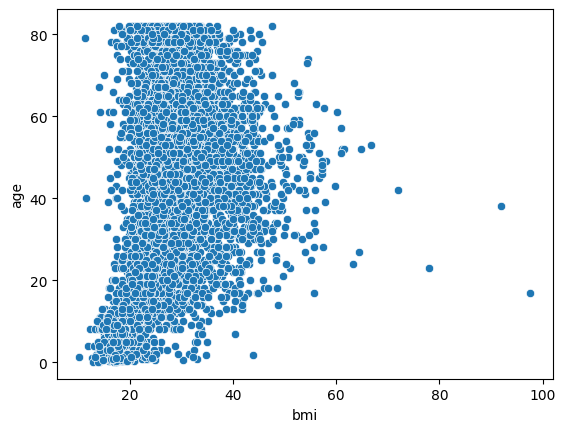

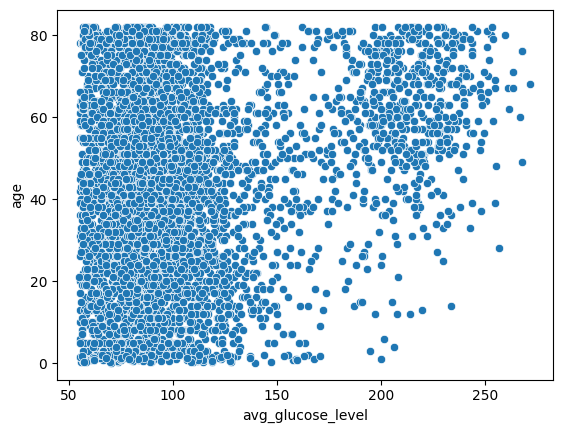

In [ ]:
visualise.scatterplot(df,"age",["bmi","avg_glucose_level"])

Correlation Plots for numerical data


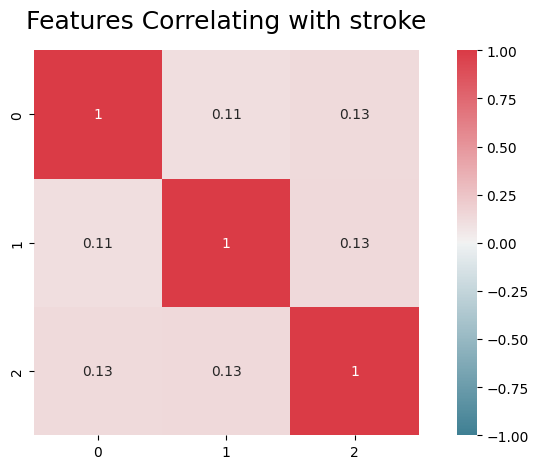

In [ ]:
visualise.correlation(df,"stroke")

Histogram plot - Analysising Data Distribution


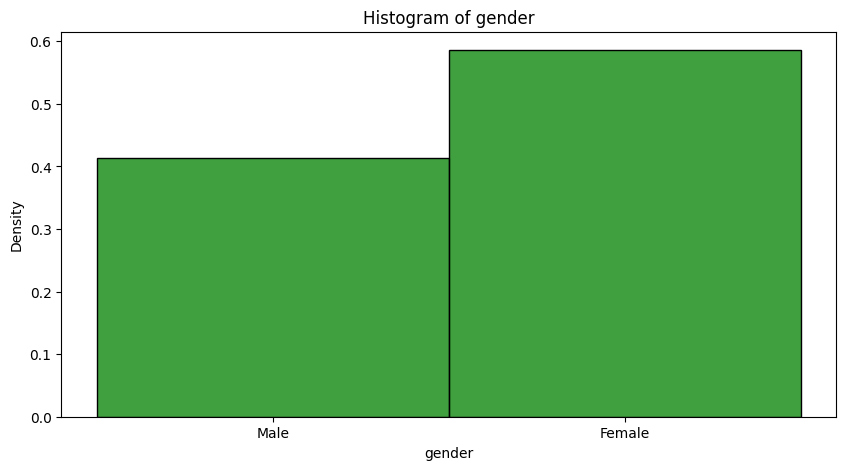

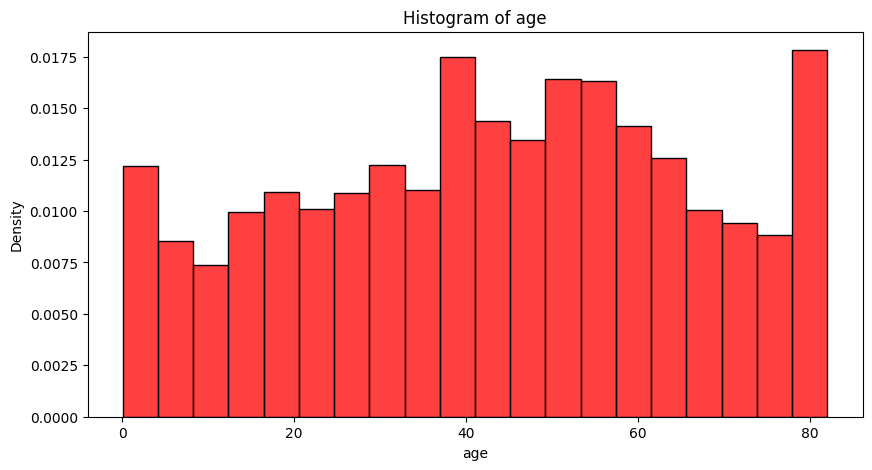

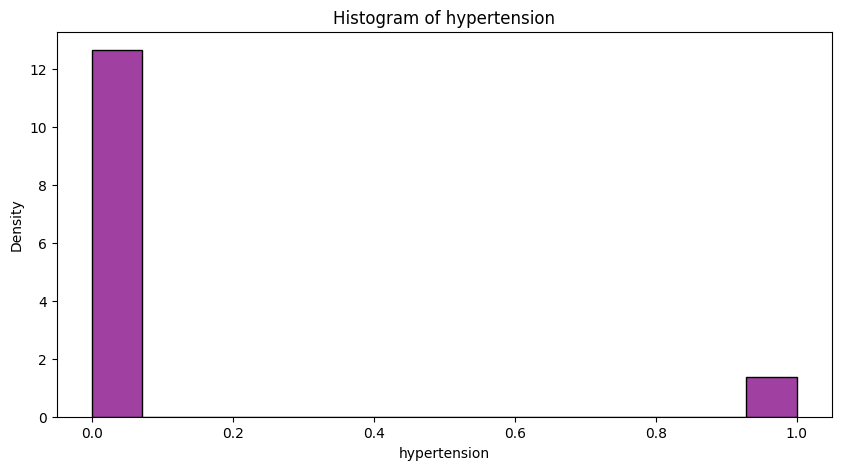

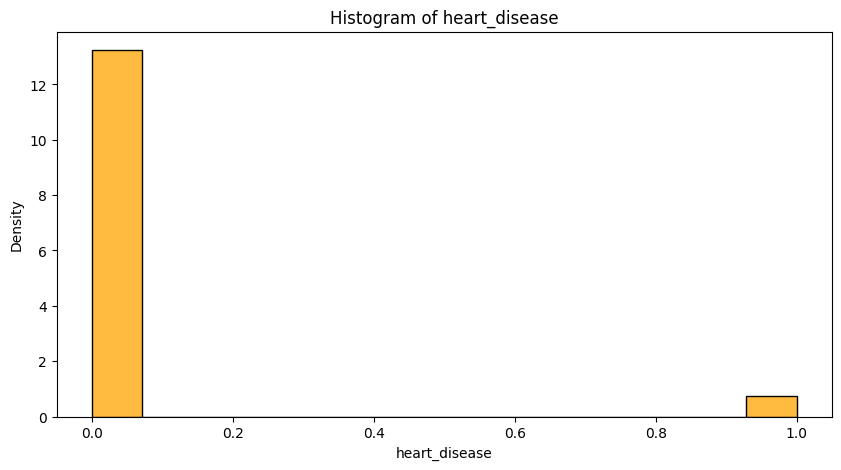

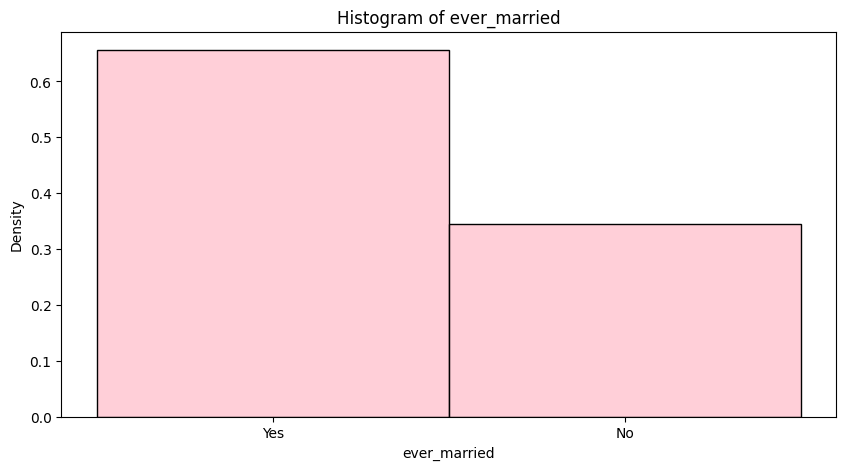

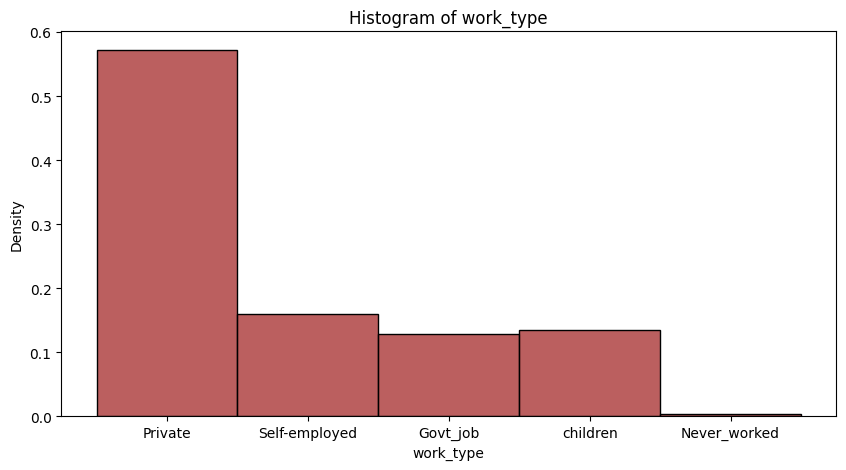

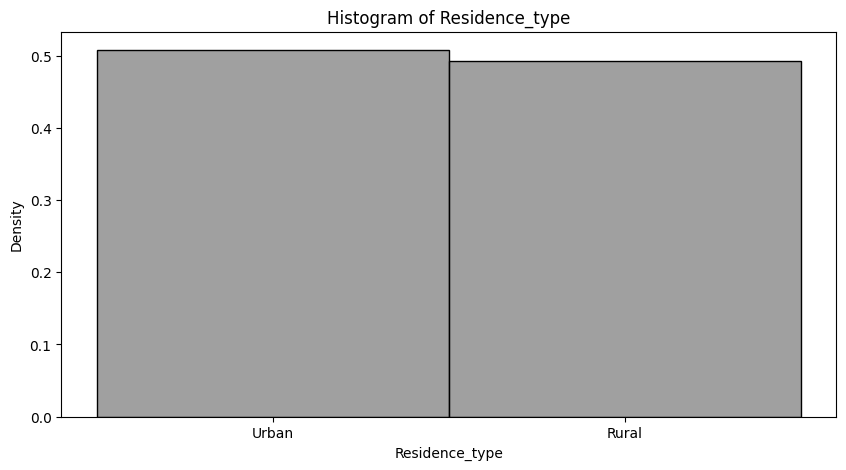

In [ ]:
colors = [ "green", "red", "purple", "orange", "pink", "brown", "gray"]
visualise.histogram(df,df.columns,colors )

Feature Selection

Through Chi-square test we saw that there is a significant association betwen sttroke and other independent variables except : gender, Residence type. But w eknow that in general females are more to stroke and the sample size is less for male this will make chi-square test to fail, chi square test is sensitive towars sample size (The number of sampleincreases the power of statistical test also increases)

In [ ]:
df=df.drop(["Residence_type","ever_married"])

In [ ]:
# Since our Dataset is highly undersampled (based on target instances) we are going to perform a over sampling method to have equal representation of both the target classes
# Using random oversampling - importing the library
from imblearn.over_sampling import RandomOverSampler

# Performing a minority oversampling
oversample = RandomOverSampler(sampling_strategy='minority')
df1=df.to_pandas(use_pyarrow_extension_array=True)
print(df)
X=df.drop("stroke").to_pandas()
y=df["stroke"].to_pandas()

# Obtaining the oversampled dataframes - testing and training
X_over, y_over = oversample.fit_resample(X, y)

shape: (5_110, 9)
┌────────┬──────┬──────────────┬───────────────┬───┬───────────────┬──────┬───────────────┬────────┐
│ gender ┆ age  ┆ hypertension ┆ heart_disease ┆ … ┆ avg_glucose_l ┆ bmi  ┆ smoking_statu ┆ stroke │
│ ---    ┆ ---  ┆ ---          ┆ ---           ┆   ┆ evel          ┆ ---  ┆ s             ┆ ---    │
│ str    ┆ f64  ┆ i64          ┆ i64           ┆   ┆ ---           ┆ f64  ┆ ---           ┆ i64    │
│        ┆      ┆              ┆               ┆   ┆ f64           ┆      ┆ str           ┆        │
╞════════╪══════╪══════════════╪═══════════════╪═══╪═══════════════╪══════╪═══════════════╪════════╡
│ Male   ┆ 67.0 ┆ 0            ┆ 1             ┆ … ┆ 228.69        ┆ 36.6 ┆ formerly      ┆ 1      │
│        ┆      ┆              ┆               ┆   ┆               ┆      ┆ smoked        ┆        │
│ Female ┆ 61.0 ┆ 0            ┆ 0             ┆ … ┆ 202.21        ┆ 36.6 ┆ never smoked  ┆ 1      │
│ Male   ┆ 80.0 ┆ 0            ┆ 1             ┆ … ┆ 105.92        ┆ 32.5

In [ ]:
categorical_features=["work_type","smoking_status","gender"]
numerical_features=["age","hypertension","heart_disease","avg_glucose_level","bmi"]

In [ ]:
numeric_transformer = Pipeline(
    steps=[("scaler", RobustScaler())]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder()) ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3 , random_state=42)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))
clf

model score: 0.770


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['work_type',
                                                   'smoking_status',
                                                   'gender'])])),
                ('classifier', LogisticRegression())])

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_grad = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", HistGradientBoostingClassifier(loss='log_loss',learning_rate=0.1, max_iter=1000, max_leaf_nodes=50, max_depth=None, min_samples_leaf=50, l2_regularization=0.0, max_bins=255, categorical_features=None, monotonic_cst=None, interaction_cst=None, warm_start=True, early_stopping=False, scoring='loss', validation_fraction=0.3, n_iter_no_change=20, tol=1e-07, verbose=0, random_state=0, class_weight=None))]
)
clf_grad.fit(X_train, y_train)
print("model score: %.3f" % clf_grad.score(X_test, y_test))
clf_grad

model score: 0.986


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['work_type',
                                                   'smoking_status',
                                                   'gender'])])),
                ('classifier',
                 HistGradientBoostingClassifier(early_stopping=False,
                                                max_iter=1000,
                                                max_leaf_nodes=50,
                                                min_samples_leaf=50,
                                                n_iter_no_change=20,
                                                random_state=0,
                                                validation_fraction=0.3,
                                                warm_start=True))])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

clf_rand= Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier",RandomForestClassifier(n_estimators=200))]
)
clf_rand.fit(X_train, y_train)
print("model score: %.3f" % clf_rand.score(X_test, y_test))
clf_rand

model score: 0.987


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['work_type',
                                                   'smoking_status',
                                                   'gender'])])),
                ('classifier', RandomForestClassifier(n_estimators=200))])

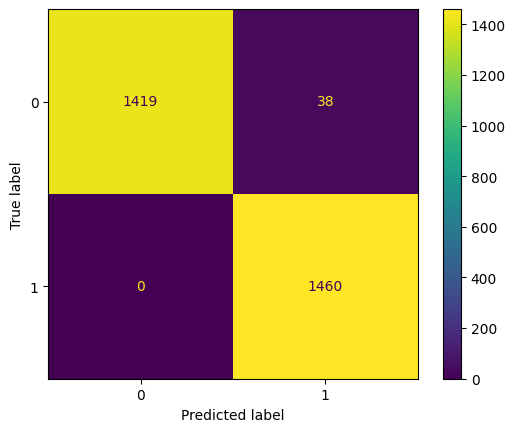

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = clf_rand.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf_rand.classes_)
disp.plot()

In [ ]:
target_names = ['stroke', 'no stroke']
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

      stroke       1.00      0.97      0.99      1457
   no stroke       0.97      1.00      0.99      1460

    accuracy                           0.99      2917
   macro avg       0.99      0.99      0.99      2917
weighted avg       0.99      0.99      0.99      2917



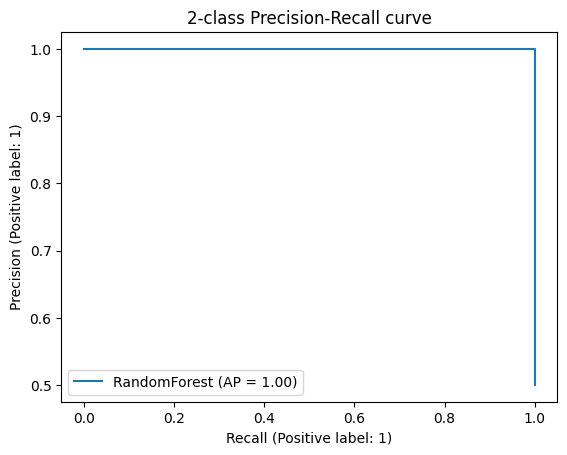

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_estimator(
    clf_rand, X_test, y_test, name="RandomForest"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
# Importing module for kfold cross validation
from sklearn import model_selection
from sklearn.model_selection import KFold

# Performing k fold cross validation using 20 splits
kfold_kridge = model_selection.KFold(n_splits=20, shuffle=True)
results_kfold = model_selection.cross_val_score(clf_rand, X_over, y_over, cv=kfold_kridge)
print("Accuracy: ", results_kfold.mean()*100)
print(results_kfold)

Accuracy:  99.15652647856618
[0.99178645 0.99383984 0.99382716 0.98971193 0.99176955 0.98971193
 0.99176955 0.98971193 0.99176955 0.99382716 0.98971193 0.99588477
 0.98559671 0.99382716 0.99176955 0.98765432 0.99588477 0.98765432
 0.99382716 0.99176955]


In [ ]:
# For the front end
import pickle

with open('model.pickle','wb') as f:
  pickle.dump(clf_rand,f)

Random Forest is found to be best performing. We can adjust the threshold for this model for making it perform better on this kind of imbalance dataset.

In [ ]:
from xgboost  import XGBClassifier
clf_xg= Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", XGBClassifier())]
)
clf_xg.fit(X_train, y_train)
print("model score: %.3f" % clf_xg.score(X_test, y_test))
clf_xg


model score: 0.972


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['work_type',
                                                   'smoking_status',
                                                   'gender'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
from sklearn import svm
clf_svm= Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier",svm.SVC(kernel="rbf"))]
)
clf_svm.fit(X_train, y_train)
print("model score: %.3f" % clf_svm.score(X_test, y_test))
clf_svm


model score: 0.828


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['work_type',
                                                   'smoking_status',
                                                   'gender'])])),
                ('classifier', SVC())])



> This project addresses the need for faster and more scalable solutions in healthcare analytics, demonstrating the potential advantages of using Polars DataFrames for stroke prediction. The outcomes will contribute to the growing field of data-driven healthcare, paving the way for more efficient and scalable predictive modeling.









